# Experiments with the Emotion6 database

Classification and visualization using the results from Emotion6 experiments.

- Load the model (create a "deploy" version)
- Read the test images from TXT files
- Generate a mosaic with the classification results

###  Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [94]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10,10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
# We added it to PYTHONPATH (e.g. from ~/.bash_profile)

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### Reading the data

We'll read the image/label pairs from our Emotion6 groundtruth, creating two lists of images (one for each label).


In [95]:
test_images_file = 'experiments/Emotion6/em6_posneg_test.txt'
samples = {}

with open(test_images_file) as f:
    for line in f:
        columns = line.split()
        label = columns[1]
        if not label in samples:
            samples[label] = []
        samples[label].append(columns[0])

for key in samples.keys():
    print 'key \"%s\": %i samples' % (key, len(samples[key]))


key "1": 201 samples
key "0": 196 samples


### Loading the model & setting up caffe

We will load the model with the best performance, i.e. the one from `e2`.

In [96]:
# todo: save the final models to experiments/Emotion6 folder, create "deploy" models
model_definition = 'experiments/Emotion6/e2.deploy.prototxt'
model_weights    = 'experiments/Emotion6/.results/e2.finetune_emotion6_iter_80000.caffemodel'
caffe.set_mode_gpu()
net = caffe.Net(model_definition,
         model_weights,
         caffe.TEST)
print 'Net model sucessfully loaded'

Net model sucessfully loaded


In [97]:
# load the mean places image 
mu = np.load('experiments/Emotion6/places205CNN_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.92972906422801), ('G', 113.25471068604384), ('R', 116.20969209889881)]


### Classifying images in the test set

In [98]:
classification_results = []
for label in samples.keys():
    for image_file in samples[label]:
        image = caffe.io.load_image(image_file)
        net.blobs['data'].data[...] = transformer.preprocess('data', image)
        # perform classification
        net.forward()
        # obtain the output probabilities
        output_prob = net.blobs['prob'].data[0]
        classification_results.append([image_file,int(label),output_prob.argmax(),output_prob.max()])

### Visualizing results

we are going to select the best scores for true positives and false positives in the test set

In [99]:
labels = [label[1] for label in classification_results]
predictions = [label[2] for label in classification_results]
from sklearn.metrics import accuracy_score
acc = accuracy_score(labels, predictions)
print 'Testing: Accuracy is %f' % acc

Testing: Accuracy is 0.778338


True Positive top 5


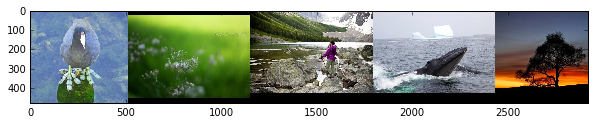

False Positive top 5


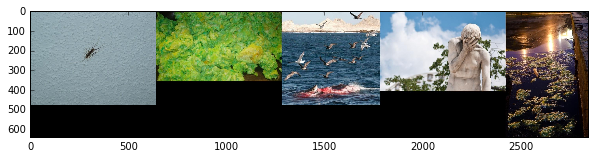

True Negative top 5


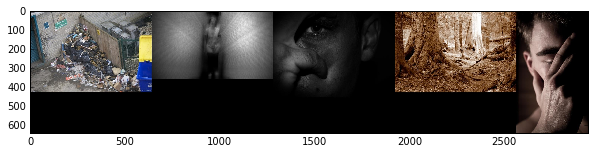

False Negative top 5


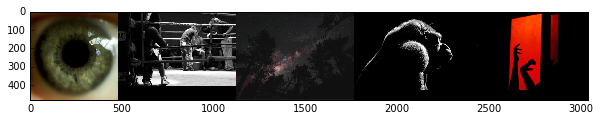

In [100]:
true_positive_top5  = sorted([elem for elem in classification_results if elem[1]==elem[2]==1],key=lambda x:x[3])[-5::]
false_positive_top5 = sorted([elem for elem in classification_results if (elem[1]==0 and elem[2]==1)],key=lambda x:x[3])[-5::]
true_negative_top5  = sorted([elem for elem in classification_results if elem[1]==elem[2]==0],key=lambda x:x[3])[-5::]
false_negative_top5 = sorted([elem for elem in classification_results if (elem[1]==1 and elem[2]==0)],key=lambda x:x[3])[-5::]


def collate_images(files, output = 'collated.jpg'):
    import sys
    from PIL import Image
    images = map(Image.open, files)
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
      new_im.paste(im, (x_offset,0))
      x_offset += im.size[0]
    new_im.save(output)

def collate_and_show(files, output='collated.jpg'):
    collate_images(files,output)
    plt.imshow(caffe.io.load_image(output))
    plt.show()

print 'True Positive top 5'
collate_and_show([elem[0] for elem in true_positive_top5],'tp_top5.jpg')
print 'False Positive top 5'
collate_and_show([elem[0] for elem in false_positive_top5],'fp_top5.jpg')
print 'True Negative top 5'
collate_and_show([elem[0] for elem in true_negative_top5],'tn_top5.jpg')
print 'False Negative top 5'
collate_and_show([elem[0] for elem in false_negative_top5],'fn_top5.jpg')
    